In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout


In [2]:
DATA_DIR = r"C:\Users\devan\AI-ML\3_NLP_Project_Document_Classification\Data"

raw_texts = []
labels = []
categories = []

for idx, folder_name in enumerate(sorted(os.listdir(DATA_DIR))):
    folder_path = os.path.join(DATA_DIR, folder_name)
    if os.path.isdir(folder_path):
        categories.append(folder_name)
        for fname in os.listdir(folder_path):
            if fname.lower().endswith(".txt"):
                fpath = os.path.join(folder_path, fname)
                with open(fpath, "r", encoding="utf-8", errors="ignore") as f:
                    raw_texts.append(f.read())
                labels.append(idx)

print("Total docs:", len(raw_texts))
print("Categories:", categories)


Total docs: 2225
Categories: ['business', 'entertainment', 'politics', 'sport', 'tech']


In [3]:

data_dir = r"C:\Users\devan\AI-ML\3_NLP_Project_Document_Classification\Data"

cleaned_texts = []
labels = []
categories = []

# Auto-detect class folders
for idx, folder_name in enumerate(sorted(os.listdir(data_dir))):
    folder_path = os.path.join(data_dir, folder_name)

    if os.path.isdir(folder_path):
        categories.append(folder_name)   # folder name = class name

        for file_name in os.listdir(folder_path):
            if file_name.lower().endswith(".txt"):
                file_path = os.path.join(folder_path, file_name)

                with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                    text = f.read()

                cleaned_texts.append(text)
                labels.append(idx)

print("Total documents:", len(cleaned_texts))
print("Detected classes:", categories)


Total documents: 2225
Detected classes: ['business', 'entertainment', 'politics', 'sport', 'tech']


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    cleaned_texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 1780
Test size: 445


In [5]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

IMPORTANT_SHORT = {"ai", "uk", "us", "eu", "tv", "vr", "pc"}

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"http\S+|www\S+", " ", text)
    # allow digits as well now
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    tokens = nltk.word_tokenize(text)
    cleaned_tokens = []
    for t in tokens:
        if t in stop_words:
            continue
        if len(t) <= 2 and t not in IMPORTANT_SHORT:
            continue
        cleaned_tokens.append(lemmatizer.lemmatize(t))
    return " ".join(cleaned_tokens)

cleaned_texts = [clean_text(t) for t in raw_texts]

print("Example BEFORE:\n", raw_texts[0][:])
print("\nAFTER:\n", cleaned_texts[0][:])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Example BEFORE:
 Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will t

In [6]:
# Detailed cleaning analysis
print("\n" + "=" * 80)
print("DETAILED CLEANING ANALYSIS")
print("=" * 80)

for i in range(min(2, len(raw_texts))):
    print(f"\n Document {i+1} - Category: {categories[labels[i]]}")
    print("-" * 80)
    
    # Show original
    print("BEFORE CLEANING (First 200 chars):")
    print(raw_texts[i][:200])
    
    # Show cleaned
    print("\nAFTER CLEANING (First 200 chars):")
    print(cleaned_texts[i][:200])
    
    # Word count
    original_words = len(raw_texts[i].split())
    cleaned_words = len(cleaned_texts[i].split())
    print(f"\nWord count: {original_words} → {cleaned_words} words (removed {original_words - cleaned_words})")
    
    # Most common words in cleaned text
    words = cleaned_texts[i].split()
    from collections import Counter
    word_freq = Counter(words)
    print(f"\nTop 10 words in cleaned text:")
    for word, count in word_freq.most_common(10):
        print(f"  {word}: {count}")



DETAILED CLEANING ANALYSIS

 Document 1 - Category: business
--------------------------------------------------------------------------------
BEFORE CLEANING (First 200 chars):
Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one o

AFTER CLEANING (First 200 chars):
sale boost time warner profit quarterly profit u medium giant timewarner jumped 13bn 600m three month december 639m year earlier firm one biggest investor google benefited sale high speed internet con

Word count: 421 → 257 words (removed 164)

Top 10 words in cleaned text:
  profit: 10
  timewarner: 7
  aol: 7
  sale: 5
  said: 5
  warner: 4
  year: 4
  internet: 4
  quarter: 4
  revenue: 4

 Document 2 - Category: business
--------------------------------------------------------------------------------
BEFORE CLEANING (First 200 chars):
Dollar gains on Greenspan speech

The dol

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    cleaned_texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 1780
Test size: 445


In [8]:
MAX_VOCAB = 20000    # max distinct words to keep
MAX_LEN = 500        # max tokens per doc (your docs are ~200–250 words, so 500 is safe)

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post", truncating="post")

print("Padded train shape:", X_train_pad.shape)
print("Padded test shape:", X_test_pad.shape)


Padded train shape: (1780, 500)
Padded test shape: (445, 500)


In [9]:
num_classes = len(categories)
vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=64,
                    input_length=MAX_LEN))

model.add(GlobalAveragePooling1D())   # collapse sequence → single vector

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

model.compile(
    loss="sparse_categorical_crossentropy",  # because y_train / y_test are integers
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


C:\Users\devan\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
X_train_pad = np.array(X_train_pad, dtype="int32")
X_test_pad = np.array(X_test_pad, dtype="int32")

y_train = np.array(y_train, dtype="int32")
y_test = np.array(y_test, dtype="int32")

print("X_train_pad:", type(X_train_pad), X_train_pad.dtype, X_train_pad.shape)
print("X_test_pad:", type(X_test_pad), X_test_pad.dtype, X_test_pad.shape)
print("y_train:", type(y_train), y_train.dtype, y_train.shape)
print("y_test:", type(y_test), y_test.dtype, y_test.shape)


X_train_pad: <class 'numpy.ndarray'> int32 (1780, 500)
X_test_pad: <class 'numpy.ndarray'> int32 (445, 500)
y_train: <class 'numpy.ndarray'> int32 (1780,)
y_test: <class 'numpy.ndarray'> int32 (445,)


In [11]:

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad,
    y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)



Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2562 - loss: 1.5797 - val_accuracy: 0.3416 - val_loss: 1.5115
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4787 - loss: 1.2278 - val_accuracy: 0.5775 - val_loss: 0.9415
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7034 - loss: 0.7240 - val_accuracy: 0.7393 - val_loss: 0.6174
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8646 - loss: 0.3793 - val_accuracy: 0.6719 - val_loss: 0.8173
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8287 - loss: 0.4952 - val_accuracy: 0.8629 - val_loss: 0.3397
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9646 - loss: 0.1297 - val_accuracy: 0.9506 - val_loss: 0.1747
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9854 - loss: 0.0627 - val_accuracy: 0.8944 - val_loss: 0.2778
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9742 - loss: 0.0811 - val_accuracy: 0.9416 - v

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
               precision    recall  f1-score   support

     business       0.97      0.93      0.95       102
entertainment       0.94      1.00      0.97        77
     politics       0.99      0.93      0.96        84
        sport       0.99      0.99      0.99       102
         tech       0.94      0.99      0.96        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



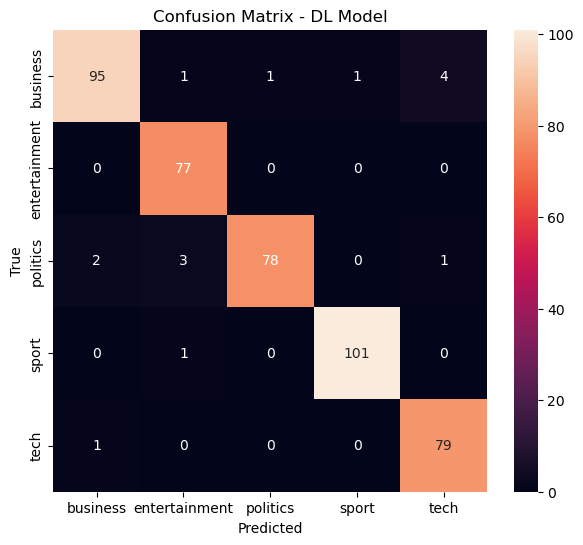

In [12]:


y_pred_probs = model.predict(X_test_pad)   # still fine to use numpy here
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=categories))

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - DL Model")
plt.show()


In [13]:
import pickle

# 1) Save the model
model.save("news_basic_dl_model.h5")
print("Model saved to news_basic_dl_model.h5")

# 2) Save the tokenizer
with open("tokenizer_basic.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved to tokenizer_basic.pkl")

# 3) (Optional) Save categories, MAX_LEN too
import json
with open("meta_basic.json", "w") as f:
    json.dump({
        "categories": categories,
        "max_len": MAX_LEN
    }, f)
print("Meta saved to meta_basic.json")


Model saved to news_basic_dl_model.h5
Tokenizer saved to tokenizer_basic.pkl
Meta saved to meta_basic.json


#Testing the saved model

In [14]:
import os
import shutil
import numpy as np
import pickle
import json
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model


In [15]:
# Load model
model = load_model("news_basic_dl_model.h5")

# Load tokenizer
with open("tokenizer_basic.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load meta
with open("meta_basic.json", "r") as f:
    meta = json.load(f)

categories = meta["categories"]
MAX_LEN = meta["max_len"]

print("Loaded categories:", categories)
print("MAX_LEN:", MAX_LEN)


Loaded categories: ['business', 'entertainment', 'politics', 'sport', 'tech']
MAX_LEN: 500


In [16]:
# NLTK setup
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
def classify_and_move_file(file_path, model, tokenizer, categories,
                           max_len, output_base_dir="Sorted_DL"):

    # 1. Read raw text
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        raw_text = f.read()

    # 2. Clean text (same as training)
    cleaned = clean_text(raw_text)

    # 3. Tokenize + pad
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len, padding="post", truncating="post")

    # 4. Predict class
    probs = model.predict(padded)[0]
    class_idx = int(np.argmax(probs))
    class_name = categories[class_idx]

    # 5. Create target folder
    os.makedirs(output_base_dir, exist_ok=True)
    target_folder = os.path.join(output_base_dir, class_name)
    os.makedirs(target_folder, exist_ok=True)

    # 6. Move file
    target_path = os.path.join(target_folder, os.path.basename(file_path))
    shutil.move(file_path, target_path)

    print(f"{file_path} → {target_path} (class: {class_name}, prob: {probs[class_idx]:.3f})")


In [18]:
def process_folder(input_folder,
                   model,
                   tokenizer,
                   categories,
                   max_len,
                   output_base_dir="Sorted_DL"):

    for fname in os.listdir(input_folder):
        if fname.lower().endswith(".txt"):
            file_path = os.path.join(input_folder, fname)
            classify_and_move_file(
                file_path,
                model,
                tokenizer,
                categories,
                max_len,
                output_base_dir=output_base_dir
            )

# Example usage:
input_folder = r"C:\Users\devan\AI-ML\3_NLP_Project_Document_Classification\New_Files"
process_folder(input_folder, model, tokenizer, categories, MAX_LEN, output_base_dir="Sorted_DL")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
C:\Users\devan\AI-ML\3_NLP_Project_Document_Classification\New_Files\test1.txt → Sorted_DL\business\test1.txt (class: business, prob: 0.996)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
C:\Users\devan\AI-ML\3_NLP_Project_Document_Classification\New_Files\test2.txt → Sorted_DL\entertainment\test2.txt (class: entertainment, prob: 0.485)


In [19]:
print("Categories:", categories)
for i, c in enumerate(categories):
    print(i, "→", c)


Categories: ['business', 'entertainment', 'politics', 'sport', 'tech']
0 → business
1 → entertainment
2 → politics
3 → sport
4 → tech


In [20]:
def debug_predict_text(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding="post", truncating="post")
    probs = model.predict(padded)[0]

    for idx, p in enumerate(probs):
        print(f"{categories[idx]:>13}: {p:.3f}")
    print("Predicted:", categories[int(np.argmax(probs))])


In [21]:
with open(r"C:\Users\devan\AI-ML\3_NLP_Project_Document_Classification\New_Files\test1.txt", "r", encoding="utf-8") as f:
    txt1 = f.read()

debug_predict_text(txt1)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\devan\\AI-ML\\3_NLP_Project_Document_Classification\\New_Files\\test1.txt'

In [ ]:
with open(r"C:\Users\devan\AI-ML\3_NLP_Project_Document_Classification\New_Files\test2.txt", "r", encoding="utf-8") as f:
    txt2 = f.read()

debug_predict_text(txt2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
     business: 0.006
entertainment: 0.989
     politics: 0.000
        sport: 0.005
         tech: 0.000
Predicted: entertainment
